# Basic modelling module

In [1]:
# make plots be included into this doc
%matplotlib inline

# Importing modules

In [2]:
import numpy as np
import pandas as pd
import os
from IPython.core.display import display, HTML
from bin.model import *
from sklearn.pipeline import Pipeline
from bin.conf import PREDICTOR_LOADERS
from bin.loader import get_predictor_data
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Constants definitions

In [3]:
SOURCE_DATA_PATH = './data' # relative (or absolute) path to the data directory
CSV_SEPARATOR = r';' # separator used in csv data files
DATA_FILE_NAMES = ['broad_leaf_GBIF.csv',# all data files should be in the same format
                   'широколиственные.csv',
                  # 'broad_leaved_herbarium_and_observation.csv',
                   'GBIF_coordinate.csv'
                  ] 
ALLOWED_COLUMNS = ['species', 'latitude', 'longitude'] # only these columns will be retained for computations
COLUMNS_DTYPES = [np.str, np.float64, np.float64] # Should have the same length as ALLOWED_COLUMNS
MODEL_SPECIES = ['quercus',
                 'quercus mongolica',
                 'quercus crispula',
                 'kalopanax septemlobus',
                 'fraxinus mandshurica'] # all  species should be given in lowercase format

# Initial set of variables (see conf.py: PREDICTOR_LOADERS parameter for details)
#VARIABLE_SET = tuple(['WKI' + str(k) for k in range(2, 7)])
#VARIABLE_SET += tuple(['CKI' + str(k) for k in range(2, 7)])
VARIABLE_SET = tuple(['BIO' + str(k) for k in range(1, 20)])
#VARIABLE_SET += ('PWKI0', 'PCKI0','IT', 'IC', 'TMINM', 'TMAXM')
#VARIABLE_SET += tuple(['PREC' + str(k) for k in range(1, 13)])
#VARIABLE_SET += tuple(['TAVG' + str(k) for k in range(1, 13)])
#VARIABLE_SET += tuple(['TMIN' + str(k) for k in range(1, 13)])
#VARIABLE_SET += tuple(['TMAX' + str(k) for k in range(1, 13)])


CLASSIFIERS = [ ('tree', DecisionTreeClassifier(random_state=10)),
                ('MaxEnt', LogisticRegression()),
                #('SVM', SVC(kernel='linear'))
                #('LDA', LinearDiscriminantAnalysis())
              ]
KFOLDS_NUMBER = 20
PSEUDO_ABSENCE_DENSITY = 1

# Source data loading and preprocessing

In [4]:
original_presence_data = pd.DataFrame({col: [] for col in ALLOWED_COLUMNS}) #initialize dataframe-accumulator
for filename in DATA_FILE_NAMES:
    try:
        # data loading procedure
        data = pd.read_csv(os.path.join(SOURCE_DATA_PATH, filename),
                           sep=CSV_SEPARATOR, dtype={a:b for a,b in zip(ALLOWED_COLUMNS, COLUMNS_DTYPES)})
    except IOError:
        print("Couldn't read the file %s." % filename)
    if any(data):
        print('The file %s succesfully loaded.' % filename)
        print('File overview:')
        data.info()
        print('='*50)
    # data concatenation procedure
    original_presence_data = pd.concat([original_presence_data, data[ALLOWED_COLUMNS]], ignore_index=True)

# make species names lowercased and stripped
original_presence_data['species'] = original_presence_data['species'].apply(str.lower).apply(str.strip)

display(HTML('<h3>Original size: %s</h3>'%original_presence_data['species'].size))

# remove duplicate rows and nan values
original_presence_data = original_presence_data.dropna().drop_duplicates(ALLOWED_COLUMNS).reset_index(drop=True)
display(HTML('<h3>The size after duplications removal: %s</h3>'%original_presence_data['species'].size))


The file broad_leaf_GBIF.csv succesfully loaded.
File overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3036 entries, 0 to 3035
Data columns (total 4 columns):
species        3036 non-null object
countrycode    3036 non-null object
latitude       3034 non-null float64
longitude      3034 non-null float64
dtypes: float64(2), object(2)
memory usage: 95.0+ KB
The file широколиственные.csv succesfully loaded.
File overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 3 columns):
species      605 non-null object
latitude     604 non-null float64
longitude    604 non-null float64
dtypes: float64(2), object(1)
memory usage: 14.3+ KB
The file GBIF_coordinate.csv succesfully loaded.
File overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443 entries, 0 to 2442
Data columns (total 3 columns):
species      2443 non-null object
latitude     2437 non-null float64
longitude    2437 non-null float64
dtypes: float64(2), object(1)
memo

## Initial dataset overview

In [5]:
display(HTML('<h3>General info:</h3>'))
original_presence_data.info()
display(HTML('<h3>Species occurences overview:</h3>'))
original_presence_data['species'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 3 columns):
latitude     2410 non-null float64
longitude    2410 non-null float64
species      2410 non-null object
dtypes: float64(2), object(1)
memory usage: 56.6+ KB


quercus mongolica         329
carpinus cordata          307
kalopanax septemlobus     303
juglans mandshurica       299
fraxinus lanuginosa       274
quercus crispula          163
phellodendron amurense    152
ulmus davidiana           135
ulmus laciniata           104
acer mono                  78
acer pictum                75
pinus koraiensis           51
fraxinus mandshurica       40
fraxinus rhynchophylla     34
juglans ailanthifolia      27
tilia amurensis            23
abies holophylla           16
Name: species, dtype: int64

# MAIN LOOP OVER ALL SPECIES

Constructing the dataset...
Removed correlated features:  {'BIO17', 'BIO9', 'BIO7', 'BIO13', 'BIO16', 'BIO10', 'BIO18', 'BIO11', 'BIO19', 'BIO6'}
Leaved features:  {'BIO1', 'BIO3', 'BIO12', 'BIO8', 'BIO4', 'BIO14', 'BIO15', 'BIO2', 'BIO5'}
Dataset is formed.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4450 entries, 0 to 4449
Data columns (total 13 columns):
BIO1         4450 non-null float64
BIO12        4450 non-null float64
BIO14        4450 non-null float64
BIO15        4450 non-null float64
BIO2         4450 non-null float64
BIO3         4450 non-null float64
BIO4         4450 non-null float64
BIO5         4450 non-null float64
BIO8         4450 non-null float64
absence      4450 non-null bool
latitude     4450 non-null float64
longitude    4450 non-null float64
species      4450 non-null object
dtypes: bool(1), float64(11), object(1)
memory usage: 421.6+ KB
Preforming recursive feature ellimination for the <tree> classifier...
Preforming recursive feature ellimination for th

The best classifier is tree. Its accuracy score is 0.9984254433806002.
Optimal predictor set (acc):  ['BIO1' 'BIO12' 'BIO8' 'BIO5']
The best classifier is MaxEnt. Its roc/auc score is 0.9991935159805762.
Optimal predictor set (auc):  ['BIO1' 'BIO3' 'BIO12' 'BIO8' 'BIO14' 'BIO5']
Statistic over all classifiers: 
AUC/ROC - Case:


,MaxEnt,tree
0,0.999194,0.993665
1,"[BIO1, BIO3, BIO12, BIO8, BIO14]","[BIO1, BIO12, BIO8, BIO5]"


Precision - Case:


,MaxEnt,tree
0,0.996182,0.998425
1,"[BIO1, BIO3, BIO12, BIO8, BIO4]","[BIO1, BIO12, BIO8, BIO5]"


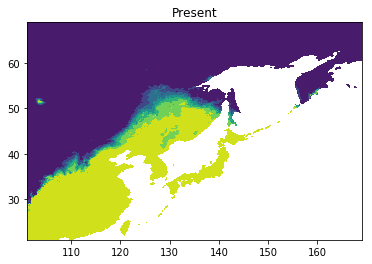

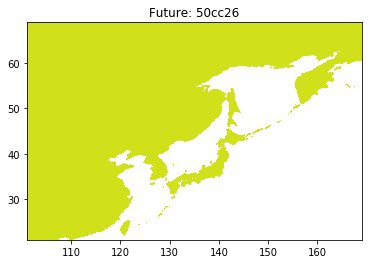

Constructing the dataset...
Removed correlated features:  {'BIO17', 'BIO9', 'BIO7', 'BIO13', 'BIO16', 'BIO10', 'BIO18', 'BIO11', 'BIO19', 'BIO6'}
Leaved features:  {'BIO1', 'BIO3', 'BIO12', 'BIO8', 'BIO4', 'BIO14', 'BIO15', 'BIO2', 'BIO5'}
Dataset is formed.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4325 entries, 0 to 4324
Data columns (total 13 columns):
BIO1         4325 non-null float64
BIO12        4325 non-null float64
BIO14        4325 non-null float64
BIO15        4325 non-null float64
BIO2         4325 non-null float64
BIO3         4325 non-null float64
BIO4         4325 non-null float64
BIO5         4325 non-null float64
BIO8         4325 non-null float64
absence      4325 non-null bool
latitude     4325 non-null float64
longitude    4325 non-null float64
species      4325 non-null object
dtypes: bool(1), float64(11), object(1)
memory usage: 409.8+ KB
Preforming recursive feature ellimination for the <tree> classifier...
Preforming recursive feature ellimination for th

The best classifier is tree. Its accuracy score is 0.9981513385664021.
Optimal predictor set (acc):  ['BIO1' 'BIO12' 'BIO8' 'BIO5']
The best classifier is MaxEnt. Its roc/auc score is 0.9997676095624815.
Optimal predictor set (auc):  ['BIO12' 'BIO8' 'BIO14' 'BIO5']
Statistic over all classifiers: 
AUC/ROC - Case:


,MaxEnt,tree
0,0.999768,0.991531
1,"[BIO12, BIO8, BIO14, BIO5]","[BIO1, BIO12, BIO8, BIO5]"


Precision - Case:


,MaxEnt,tree
0,0.996071,0.998151
1,"[BIO12, BIO8, BIO14, BIO5]","[BIO1, BIO12, BIO8, BIO5]"


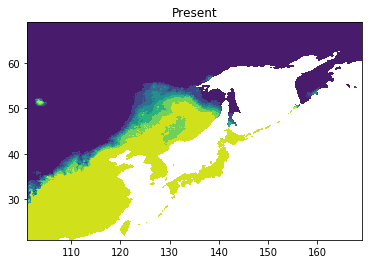

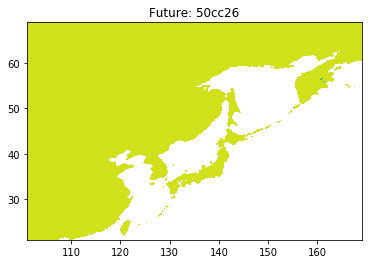

Constructing the dataset...


UnboundLocalError: local variable 'result' referenced before assignment

In [6]:

for species in MODEL_SPECIES:
    display(HTML('<h5>=============== %s ======================</h5>' % species))
    classifier_stats_acc, classifier_stats_auc = [], []
    model = Pipeline([('select_species', SelectSpecies(species)), 
                      ('prune_suspicious', PruneSuspiciousCoords()),
                      ('ps_absence', FillPseudoAbsenceData(density=PSEUDO_ABSENCE_DENSITY)),
                      ('fill_env', FillEnvironmentalData(VARIABLE_SET)),
                      ('fill_by_cond', FillPseudoAbsenceByConditions(species=species, similarity=0.2, density=1)),
                      ('exclude_by_corr', CorrelationPruner(threshold=0.9, variables=VARIABLE_SET))
                     ]
                     )
    print("Constructing the dataset...")
    aux_result = model.fit_transform(original_presence_data)
    current_variable_set = set(VARIABLE_SET).intersection(set(aux_result.columns.values))
    print("Removed correlated features: ", set(VARIABLE_SET) - current_variable_set)
    print("Leaved features: ", current_variable_set)
    current_variable_set = list(current_variable_set)
    X, y = aux_result[current_variable_set].values, list(map(int, ~aux_result.absence))
    print("Dataset is formed.")
    aux_result.info()
    for name, clf in CLASSIFIERS:
        std_clf = TweakedPipeline([('scaler', StandardScaler()),
                         ('classificator', clf)])
        print("Preforming recursive feature ellimination for the <%s> classifier..." % name)
        rfecv_acc = RFECV(estimator=std_clf, step=1, cv=StratifiedKFold(KFOLDS_NUMBER, shuffle=True),
                      scoring='accuracy')
        rfecv_acc.fit(X, y)
        acc_score = np.array(rfecv_acc.grid_scores_)[np.argmax(rfecv_acc.grid_scores_)]
        rfecv_auc = RFECV(estimator=std_clf, step=1, cv=StratifiedKFold(KFOLDS_NUMBER, shuffle=True),
                      scoring='roc_auc')
        rfecv_auc.fit(X, y)
        auc_score = np.array(rfecv_auc.grid_scores_)[np.argmax(rfecv_auc.grid_scores_)]
        classifier_stats_acc.append((name, acc_score, std_clf, rfecv_acc.support_))
        classifier_stats_auc.append((name, auc_score, std_clf, rfecv_auc.support_))
    acc_optimal_name, acc_optimal_score, acc_optimal_clf, acc_optimal_mask = tuple(classifier_stats_acc[np.argmax(list(map(lambda x: x[1], classifier_stats_acc)))])
    auc_optimal_name, auc_optimal_score, auc_optimal_clf, auc_optimal_mask = tuple(classifier_stats_auc[np.argmax(list(map(lambda x: x[1], classifier_stats_auc)))])
    display(HTML('<h5> --------------- Summary for %s: --------------- </h5>' % species))
    print("The best classifier is %s. Its accuracy score is %s." % (acc_optimal_name, acc_optimal_score))
    print("Optimal predictor set (acc): ",  np.array(current_variable_set)[acc_optimal_mask])
    print("The best classifier is %s. Its roc/auc score is %s." % (auc_optimal_name, auc_optimal_score))
    print("Optimal predictor set (auc): ",  np.array(current_variable_set)[auc_optimal_mask])
    print("Statistic over all classifiers: ")
    print("AUC/ROC - Case:")
    df = pd.DataFrame({n[0]: [n[1], np.array(current_variable_set)[n[-1]][:5]] for n in classifier_stats_auc})
    display(df)
    print("Precision - Case:")
    df = pd.DataFrame({n[0]: [n[1], np.array(current_variable_set)[n[-1]][:5]] for n in classifier_stats_acc})
    display(df)
    display(HTML('<h5> %s </h5>' % ("~" * 90,)))
    
    # ---- 
    LATS = np.linspace(21, 69, 1000)
    LONS = np.linspace(101, 169, 1000)
    LATS_GRID, LONS_GRID = np.meshgrid(LATS, LONS)
    
    optimal_vars = list(np.array(current_variable_set)[auc_optimal_mask])
    
    fill_env = FillEnvironmentalData(optimal_vars)
    map_df = pd.DataFrame({'latitude': LATS_GRID.ravel(),
                           'longitude': LONS_GRID.ravel()})
    X, y = aux_result[optimal_vars].values, list(map(int, ~aux_result.absence))
    auc_optimal_clf.fit(X, y)
    #fill_env.fit(map_df)

    # ---- Current distribution
    filled_df = fill_env.transform_nans(map_df)
    XMAP = filled_df.loc[:, optimal_vars].values
    nan_mask = np.any(np.isnan(XMAP), axis=1)
    predictions = np.zeros((len(nan_mask), 2)) * np.nan
    
    predictions[~nan_mask, :] = auc_optimal_clf.predict_proba(XMAP[~nan_mask,:])
    presence_proba_current = predictions[:, 1]
    plt.figure()
    plt.contourf(LONS_GRID, LATS_GRID, presence_proba_current.reshape(1000,1000))
    plt.title('Present')
    plt.show()
    
    fill_env = FillEnvironmentalData(optimal_vars, postfix='_50cc26')
    filled_df = fill_env.transform_nans(map_df)
    XMAP_f = filled_df.loc[:, optimal_vars].values
    nan_mask_future = np.any(np.isnan(XMAP_f), axis=1)
    predictions_future = np.zeros((len(nan_mask_future), 2)) * np.nan
    
    predictions_future[~nan_mask_future, :] = auc_optimal_clf.predict_proba(XMAP_f[~nan_mask_future,:])
    presence_proba_future = predictions_future[:, 1]
    plt.figure()
    plt.contourf(LONS_GRID, LATS_GRID, presence_proba_future.reshape(1000,1000))
    plt.title('Future: 50cc26')
    plt.show()
    
    
    
    
    
   